In [10]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
from sklearn.model_selection import train_test_split
import numpy as np
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# os.environ["CUDA_VISIBLE_DEVICES"]="0";   

# Text Classification with Hugging Face Transformers in *ktrain*

As of v0.8.x, *ktrain* now includes an easy-to-use, thin wrapper to the Hugging Face transformers library for text classification.

## Load Data Into Arrays

In [12]:
NEWS_PATH = '../news_scraper/news_articles'

In [13]:
x = []
y = []

for topic in os.listdir(NEWS_PATH):
    for stance in os.listdir(os.path.join(NEWS_PATH, topic)):
        for file in os.listdir(os.path.join(NEWS_PATH, topic, stance)):
            with open(os.path.join(NEWS_PATH, topic, stance, file), 'r') as f:
                x.append(f.read())
            y.append(stance)

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
print(f'Size of training set: {len(x_train)}')
print(f'Size of test set: {len(x_test)}')

Size of training set: 907
Size of test set: 448


## STEP 1: Preprocess Data and Build a Transformer Model

For `MODEL_NAME`, *ktrain* supports both the "official" built-in models [available here](https://huggingface.co/transformers/pretrained_models.html) and the [community-upoaded models available here](https://huggingface.co/models).

In [18]:
import ktrain
from ktrain import text
MODEL_NAME = 'distilbert-base-uncased'
t = text.Transformer(MODEL_NAME, maxlen=500)
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)

preprocessing train...
language: en
train sequence lengths:
	mean : 871
	95percentile : 2200
	99percentile : 4707


/home/edwardli/miniconda3/envs/ktrain/lib/python3.6/site-packages/ktrain/text/preprocessor.py:519: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 813
	95percentile : 1918
	99percentile : 3485


ResourceExhaustedError: OOM when allocating tensor with shape[30522,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:TruncatedNormal]

Note that `x_train` and `x_test` are the raw texts that look like this:
```python
x_train = ['I hate this movie.', 'I like this movie.']
```
The labels are arrays in one of the following forms:
```python
# string labels
y_train = ['negative', 'positive']
# integer labels
y_train = [0, 1]
# multi or one-hot encoded labels
y_train = [[1,0], [0,1]]
```
In the latter two cases, you must supply a `class_names` argument to the `Transformer` constructor, which tells *ktrain* how indices map to class names.  In this case, `class_names=['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']` because 0=alt.atheism, 1=comp.graphics, etc.

## STEP 2 [Optional]: Estimate a Good Learning Rate

Learning rates between `2e-5` and `5e-5` tend to work well with transformer models based on papers from Google. However, we will run our learning-rate-finder for two epochs to estimate the LR on this particular dataset.

As shown below, our results are consistent Google's findings.

simulating training for different learning rates... this may take a few moments...
Train for 376 steps
Epoch 1/2
376/376 [==============================] - 143s 381ms/step - loss: 1.0772 - accuracy: 0.5000
Epoch 2/2
300/376 [======================>.......] - ETA: 27s - loss: 8.5420 - accuracy: 0.2368

done.
Visually inspect loss plot and select learning rate associated with falling loss


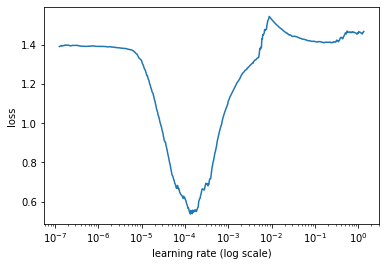

In [4]:
learner.lr_find(show_plot=True, max_epochs=2)

## STEP 3: Train Model

Train using a [1cycle learning rate schedule](https://arxiv.org/pdf/1803.09820.pdf).

In [5]:
learner.fit_onecycle(8e-5, 4)



begin training using onecycle policy with max lr of 8e-05...
Train for 377 steps, validate for 47 steps
Epoch 1/4
377/377 [==============================] - 166s 441ms/step - loss: 0.6579 - accuracy: 0.7616 - val_loss: 0.2364 - val_accuracy: 0.9228
Epoch 2/4
377/377 [==============================] - 165s 439ms/step - loss: 0.1554 - accuracy: 0.9553 - val_loss: 0.3395 - val_accuracy: 0.9041
Epoch 3/4
377/377 [==============================] - 166s 440ms/step - loss: 0.0992 - accuracy: 0.9716 - val_loss: 0.2155 - val_accuracy: 0.9407
Epoch 4/4
377/377 [==============================] - 166s 440ms/step - loss: 0.0288 - accuracy: 0.9942 - val_loss: 0.1991 - val_accuracy: 0.9501


## STEP 4: Evaluate/Inspect Model

In [6]:
learner.validate(class_names=t.get_classes())

                        precision    recall  f1-score   support

           alt.atheism       0.96      0.89      0.93       319
         comp.graphics       0.95      0.98      0.97       389
               sci.med       0.96      0.94      0.95       396
soc.religion.christian       0.93      0.98      0.95       398

              accuracy                           0.95      1502
             macro avg       0.95      0.95      0.95      1502
          weighted avg       0.95      0.95      0.95      1502



array([[285,   5,  11,  18],
       [  3, 381,   3,   2],
       [  4,  11, 371,  10],
       [  5,   3,   0, 390]])

In [7]:
# the one we got most wrong
learner.view_top_losses(n=1, preproc=t)

----------
id:306 | loss:6.97 | true:soc.religion.christian | pred:comp.graphics)



In [8]:
# understandable mistake - this sci.med post talks a lot about computer graphics
print(x_test[306])

From: regy105@cantva.canterbury.ac.nz (James Haw)
Subject: Presentation Package for preaching?
Organization: University of Canterbury, Christchurch, New Zealand
Lines: 16

Hi,
   What presentation package would you recommend for a Bible teacher?
   I've checked out Harwards Graphics for Windows. I think its more
suitable for sales people than for preachers or Bible teachers to present
an outline of a message.

   I'm looking for one that:
*  is great for overhead projector slides.
*  has or imports clip arts
*  works with Word for Windows or imports Word for Windows files.
*  works with inkjet printers
   If you know of any that meets part or all of the above, please let me know.
Please email your response as I don't keep up with the newsgroup.

Thanking you in advance,
James.



## STEP 5: Make Predictions on New Data in Deployment

In [9]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

In [10]:
predictor.predict('Jesus Christ is the central figure of Christianity.')

'soc.religion.christian'

In [12]:
predictor.explain('Jesus Christ is the central figure of Christianity.')

In [13]:
predictor.save('/tmp/my_20newsgroup_predictor')

In [14]:
reloaded_predictor = ktrain.load_predictor('/tmp/my_20newsgroup_predictor')

In [15]:
reloaded_predictor.predict('Jesus Christ is the central figure of Christianity.')

'soc.religion.christian'

In [16]:
reloaded_predictor.predict_proba('Jesus Christ is the central figure of Christianity.')

array([1.9110834e-03, 5.9577124e-04, 4.4542018e-04, 9.9704772e-01],
      dtype=float32)

In [17]:
reloaded_predictor.get_classes()

['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']